# **Anomaly Detection in Time Series Using Isolation Forest**

##  **1. Introduction to Isolation Forest**
Isolation Forest (iForest) is a tree-based, unsupervised machine learning algorithm tailored for anomaly detection. Unlike density or distance-based models, it explicitly isolates anomalies instead of profiling normal points. The algorithm is based on the idea that anomalies are few and significantly different, making them easier to isolate through recursive random partitioning.

Each tree in an Isolation Forest randomly selects a feature and then a split value. Anomalies, being distinct, usually require fewer partitions to isolate and hence appear at shallower depths in the trees. The anomaly score is derived from the average path length across all trees in the ensemble. Points with shorter average path lengths are more likely to be anomalies.




## **2. Why Use Isolation Forest for Time Series?**
Although Isolation Forest is naturally designed for independent tabular data, it can be extended to time series through temporal feature engineering. By creating rolling window features such as lag, mean, and standard deviation, we transform sequential data into a structure suitable for iForest while capturing its temporal dynamics.




###  Comparison Table

| Aspect                        | **Non-Time Series Data**                                     | **Time Series Data**                                               |
|------------------------------|---------------------------------------------------------------|---------------------------------------------------------------------|
| **Data Structure**           | Independent records with no inherent order                    | Sequential data ordered over time                                  |
| **Isolation Forest Assumption** | Points are independent and identically distributed (i.i.d.) | Ignores temporal dependencies                                      |
| **Common Use Cases**         | Fraud detection, manufacturing defects, user behavior logs   | Sensor data, system monitoring, financial series                   |
| **Direct Applicability**     |  Well-suited                                                |  Limited (temporal patterns ignored)                             |
| **Preprocessing Needed**     | Minimal (standard scaling, missing value imputation)         | Often requires rolling windows, lag features, or differencing      |
| **Anomaly Meaning**          | Outliers in feature space                                    | Deviations from normal temporal pattern                            |
| **Visualization**            | Scatter plots, dimensionality reduction                      | Line plots over time                                               |


## **3. Real-World Applications**
* Banking & E-Commerce: Spotting fraudulent transactions.

* Cybersecurity: Detecting abnormal network traffic or intrusions.

* Manufacturing: Identifying faults in machinery from sensor data.

* Healthcare: Catching outlier health signals in patient monitoring systems.

* IoT Systems: Spotting faults in streaming telemetry or smart home devices.

## **4. Implementation on Time Series Dataset**

In [3]:
#Step 1: Load and Inspect the Data
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
import plotly.graph_objects as go

df = pd.read_csv('complex.csv')# change to your dataset address
df.columns = df.columns.str.strip()
df.head()

,time,s1,s2,s3
0,0,1.000000,2.00000,0.700000
1,1,1.010000,1.99995,0.707000
2,2,1.019999,1.99980,0.713999
3,3,1.029996,1.99955,0.720997
4,4,1.039989,1.99920,0.727993


In [4]:
# Step 2: Create Time-based Features
window_size = 10
for col in ['s1', 's2', 's3']:
    df[f'{col}_mean'] = df[col].rolling(window=window_size).mean()
    df[f'{col}_std'] = df[col].rolling(window=window_size).std()
    df[f'{col}_lag1'] = df[col].shift(1)
    df[f'{col}_lag2'] = df[col].shift(2)

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [5]:
# Step 3: Independent Isolation Forest for Each Sensor
for sensor in ['s1', 's2', 's3']:
    features = [f'{sensor}_mean', f'{sensor}_std', f'{sensor}_lag1', f'{sensor}_lag2']
    X = df[features]
    X_scaled = StandardScaler().fit_transform(X)

    model = IsolationForest(n_estimators=100, contamination=0.02, random_state=42)
    df[f'{sensor}_anomaly'] = model.fit_predict(X_scaled)
    df[f'{sensor}_anomaly'] = df[f'{sensor}_anomaly'].apply(lambda x: 1 if x == -1 else 0)

In [6]:
# Step 4: Interactive Plot (Sensor-specific anomalies only)
def create_independent_anomaly_plot(df):
    fig = go.Figure()
    sensors = ['s1', 's2', 's3']
    buttons = []

    for i, sensor in enumerate(sensors):
        normal = df[df[f'{sensor}_anomaly'] == 0]
        anomaly = df[df[f'{sensor}_anomaly'] == 1]

        fig.add_trace(go.Scatter(
            x=normal['time'],
            y=normal[sensor],
            mode='markers',
            name=f'{sensor} - Normal',
            marker=dict(color='blue', size=4),
            visible=(i == 0)
        ))

        fig.add_trace(go.Scatter(
            x=anomaly['time'],
            y=anomaly[sensor],
            mode='markers',
            name=f'{sensor} - Anomaly',
            marker=dict(color='red', size=6),
            visible=(i == 0)
        ))

        visibility = [False] * 6
        visibility[2 * i] = True
        visibility[2 * i + 1] = True

        buttons.append(dict(
            label=sensor,
            method='update',
            args=[{'visible': visibility},
                  {'title': f'Anomaly Detection on {sensor}'}]
        ))

    fig.update_layout(
        updatemenus=[dict(
            active=0,
            buttons=buttons,
            x=0.1,
            xanchor="left",
            y=1.2,
            yanchor="top"
        )],
        title="Anomaly Detection on s1",
        xaxis_title='Time',
        yaxis_title='Sensor Value',
        hovermode='closest'
    )

    fig.show()

# Call the interactive plot function
create_independent_anomaly_plot(df)

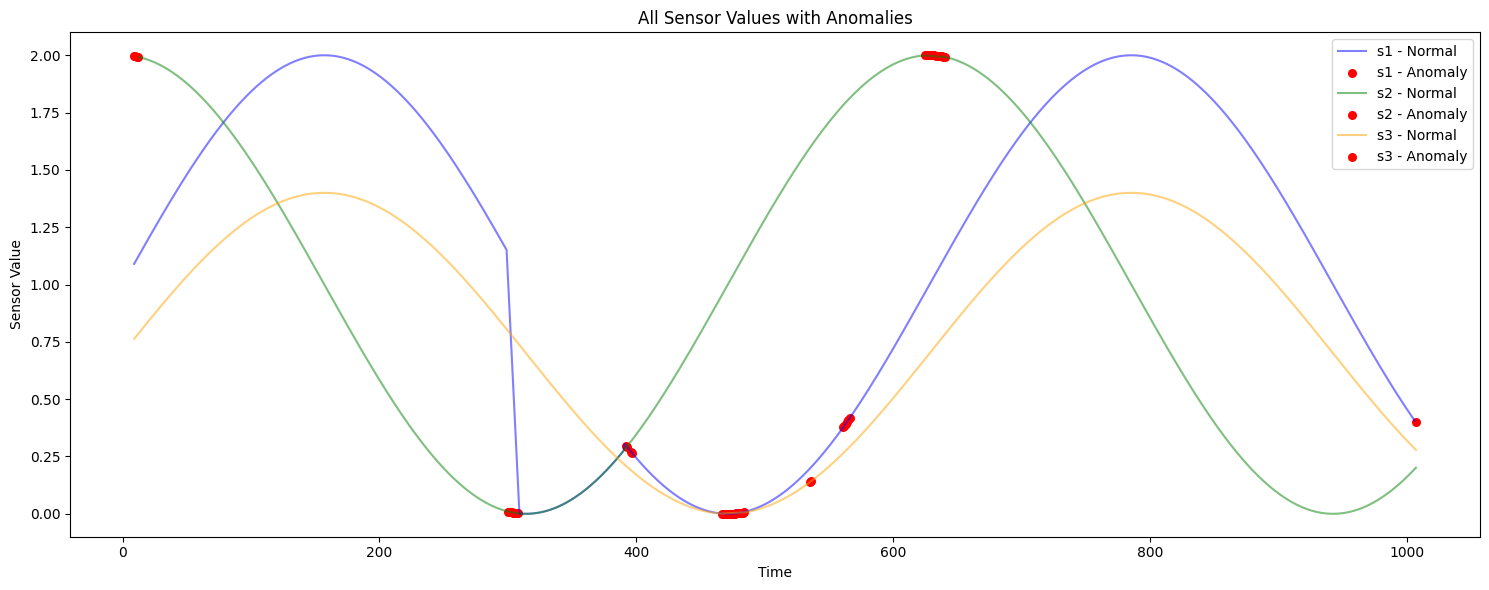

In [8]:
def plot_all_sensors_with_anomalies(df):
    plt.figure(figsize=(15, 6))

    sensors = ['s1', 's2', 's3']
    colors = ['blue', 'green', 'orange']

    for i, sensor in enumerate(sensors):
        # Plot normal sensor values
        normal = df[df[f'{sensor}_anomaly'] == 0]
        plt.plot(normal['time'], normal[sensor], label=f'{sensor} - Normal', color=colors[i], alpha=0.5)

        # Plot anomalies for that sensor
        anomaly = df[df[f'{sensor}_anomaly'] == 1]
        plt.scatter(anomaly['time'], anomaly[sensor], color='red', label=f'{sensor} - Anomaly', s=30)

    plt.title("All Sensor Values with Anomalies")
    plt.xlabel("Time")
    plt.ylabel("Sensor Value")
    plt.legend()
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# Call the function
plot_all_sensors_with_anomalies(df)

## **5. Evaluation and Result Summary**
From the visual patterns and anomaly flags:

* Detected anomalies generally occur when the regular trend (increasing or stable values) is interrupted.

* The model performed well in maintaining curve patterns and flagging deviations.

* This method is unsupervised and highly scalable, making it appropriate for streaming or periodic time series data.

## **6. Conclusion and Future Use**
Isolation Forest, combined with temporal feature engineering, proves effective for anomaly detection in time series where labeled data is unavailable. It maintains simplicity, interpretability, and efficiency. We recommend its continued use in future trimesters, especially in:

* Real-time anomaly monitoring pipelines.

* Scenarios where periodic pattern deviation is critical (e.g., environmental monitoring, predictive maintenance).

For integration:

* Automate daily feature extraction and model scoring.

* Store anomaly labels for periodic review or alerts.

* Optionally retrain model monthly using new data windows.

## **7. References**
Wikipedia. (2025). Isolation Forest. https://en.wikipedia.org/wiki/Isolation_forest

Afroz, P. (2025). Anomaly Detection Using Isolation Forest. Kaggle. https://www.kaggle.com/code/pythonafroz/anomaly-detection-using-isolation-forest

Medium. (2025). Anomaly Detection with Isolation Forest Visualization. https://medium.com/data-science/anomaly-detection-with-isolation-forest-visualization-23cd75c281e2

## **8. Authors**
This notebook was authored by:
- **Li Wan.** Postgraduate student of Deakin University, Majoring in Data Science.
- **Arnav Ahuja.** Undergraduate student of Deakin University, Bachelor in Data Science.
